In [1]:
import torch
import pandas as pd
from run_grid_experiments import run_grid_experiments

SMOKE_TEST None


In [4]:
seeds = list(range(1))
# n_inits = [2, 4, 8, 10]
n_inits = [10]
noise_levels = [5]#[1, 5, 10, 20]
noise_bools = [True]
budget = 30



sm_list = {}
df = pd.DataFrame(columns=["n_init", "noise_level", "seed", "noise_bool", "best"])
for noise_bool in noise_bools:
    for n_init in n_inits:
        for noise_level in noise_levels:
            sm_agg = torch.zeros((len(seeds), n_init+budget))
            for idx, seed in enumerate(seeds):
                X, Y, Y_real, model = torch.load(f"results/Schwe_n_init_{n_init}_noiselvl_{noise_level}_budget_{budget}_seed_{seed}_noise_{noise_bool}.pt")
                sliding_min = torch.zeros(Y.shape[0])
                for i in range(Y_real.shape[0]):
                    sliding_min[i] = Y_real[:i+1].min().item()
                
                sm_agg[idx] = sliding_min
                sm = pd.Series(sliding_min.numpy())
                
                df = pd.concat([df, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],
                                                  "best": [sliding_min[-1].item()]})])
                
            sm_mean = sm_agg.mean(0)
            sm_std = sm_agg.std(0)
            sm_list[(n_init, noise_level, noise_bool)] = (sm_mean, sm_std)
df                

/tmp/ipykernel_26460/2834717507.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({"n_init": [n_init], "noise_level": [noise_level], "seed": [seed], "noise_bool": [noise_bool],
/tmp/ipykernel_26460/2834717507.py:27: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  sm_std = sm_agg.std(0)


,n_init,noise_level,seed,noise_bool,best
0,10,5,0,True,767.079651


In [5]:
Y_real

tensor([835.0243, 826.3714, 885.8375, 861.5043, 852.6030, 872.2106, 859.8699,
        827.3935, 841.4297, 838.4979, 830.3094, 835.5397, 817.9036, 876.8677,
        800.5196, 819.3487, 767.0797, 830.2089, 810.5448, 822.9490, 819.5395,
        817.6187, 804.5982, 837.9658, 829.5634, 821.7871, 856.8130, 821.8134,
        889.2534, 851.8686, 787.5237, 799.3164, 778.4625, 794.3905, 790.8689,
        779.4604, 779.5393, 767.0797, 779.5594, 851.0072], dtype=torch.float64)

In [6]:
Y

tensor([843.8446, 828.3721, 890.7312, 872.7088, 861.9408, 867.3242, 864.6204,
        826.6367, 840.9136, 840.5509, 831.0296, 842.8110, 821.7088, 877.4761,
        802.7390, 821.0171, 774.5501, 829.1831, 812.1102, 818.6785, 806.7745,
        820.8868, 808.9204, 834.2550, 840.9122, 814.5153, 857.0418, 820.8775,
        896.9173, 859.2154, 788.2984, 801.2072, 774.0236, 784.4865, 789.1293,
        780.2421, 785.6907, 773.0916, 777.6227, 849.4957], dtype=torch.float64)

In [92]:

# slide_min line plot
import matplotlib.pyplot as plt

df_no_noise = df[df["noise_bool"] == False]
df_noise = df[df["noise_bool"] == True]



# # df = df.groupby(["n_init", "noise_level", "noise_bool"]).agg({"min": ["mean", "std"]})
df_no_noise = df_no_noise.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})
df_noise = df_noise.groupby(["n_init", "noise_level"]).agg({"best": ["mean", "std"]})

# df_no_noise
df_noise

best     
                          mean  std
n_init noise_level                 
10     1            767.079651  0.0
       5            767.079651  0.0
       10           767.079651  0.0
       20           767.079651  0.0

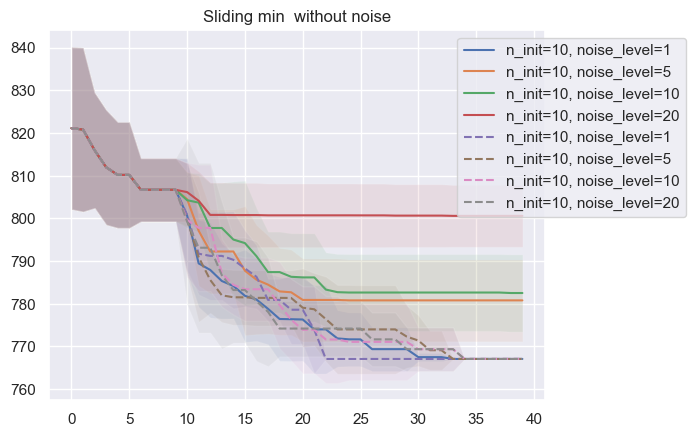

In [93]:

fig, ax = plt.subplots()

for idx, row in df_no_noise.iterrows():
    mean = sm_list[(idx[0], idx[1], False)][0]
    std = sm_list[(idx[0], idx[1], False)][1]
    plt.plot(mean, label=f"n_init={idx[0]}, noise_level={idx[1]}")
    plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)
    
for idx, row in df_noise.iterrows():
    mean = sm_list[(idx[0], idx[1], True)][0]
    std = sm_list[(idx[0], idx[1], True)][1]
    plt.plot(mean, label=f"n_init={idx[0]}, noise_level={idx[1]}", linestyle="--")
    plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.1)

# aaawaaay
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.title("Sliding min  without noise")
plt.show()
